In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
import pickle
import copy
import os

from torch.utils.data import Dataset, DataLoader
from torch import nn
from models.models import LSTM_net

from ignite.handlers.param_scheduler import create_lr_scheduler_with_warmup

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

from typing import Dict, Any, Tuple, List, Union, Sequence, Callable


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

from utils.attacks import IterGradAttack, fgsm_attack, fgsm_reg_attack
from utils.attacks import (fgsm_disc_attack, fgsm_attack, fgsm_reg_attack, 
simba_binary, simba_binary_reg, simba_binary_disc_reg)
from utils.discrim_attack import HideAttackExp
from utils.data import load_Ford_A, transform_Ford_A, MyDataset
import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [2]:
col = 'FordA'

import sktime
from sktime.datasets import load_from_tsfile

x_train, y_train = load_from_tsfile("data/Ford_A/FordA_TRAIN.ts")
x_test, y_test = load_from_tsfile("data/Ford_A/FordA_TEST.ts")

def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

x_train.shape, x_test.shape, y_train.shape, y_test.shape

(array([-1,  1]), array([1846, 1755]))
(array([-1,  1]), array([681, 639]))


((3601, 500), (1320, 500), (3601,), (1320,))

In [3]:
def transform_X(X):
    np_data = []
    lens = []
    for i in range(len(X)):
        line = X.iloc[i, 0]
        lens.append(len(line))
        np_data.append(line)
        
    #print(np.mean(lens), np.std(lens))
    return np.array(np_data)

(36010, 50) (13200, 50) (36010, 1) (13200, 1)


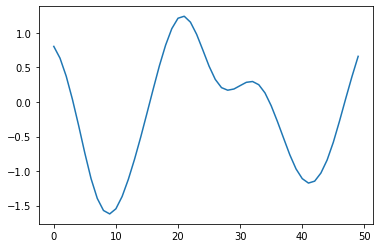

In [4]:
window = 50
len_seq = x_train.shape[1]
n_patches = len_seq//window

X_train = np.vstack([x_train[:, i:i+window] for i in range(n_patches)])
X_test = np.vstack([x_test[:, i:i+window] for i in range(n_patches)])

y_train = np.array([(int(y)+1) // 2 for y in y_train])
y_test = np.array([(int(y)+1) // 2 for y in y_test])

y_train = np.vstack([y_train.reshape(-1, 1) for i in range(n_patches)])
y_test = np.vstack([y_test.reshape(-1, 1) for i in range(n_patches)])

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

plt.plot(X_train[1])

In [5]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor =torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.int32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int32)

# Modelling

In [6]:
class MyDataset(Dataset):
    def __init__(self, X, y, window=50):
        super().__init__()
        self.X = X
        self.y = y
        self.window=window

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        
#         start_ind = np.random.randint(0, len(X) - self.window)
#         X = X[start_ind:start_ind+self.window]
        X = X.reshape([-1, 1])
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return X, y

    
BS = 64    
train_loader = DataLoader(MyDataset(X_train[50:], y_train[50:]), batch_size=BS, shuffle=True)
test_loader = DataLoader(MyDataset(X_test[50:], y_test[50:]), batch_size=BS, shuffle=False)

In [7]:
class LSTM_net(nn.Module):
    def __init__(self, hidden_dim, n_layers, output_dim=1, dropout=0.2):
        super().__init__()
        self.rnn = nn.LSTM(1, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, data):
        
        packed_output, (hidden, cell) = self.rnn(data)
        hidden = hidden.reshape(hidden.shape[1], hidden.shape[2])
        
        hidden = self.dropout(hidden)
        output = self.relu(self.fc1(hidden))
        output = self.fc2(self.dropout(output))
        output = torch.sigmoid(output)
            
        return output

In [8]:
def train_step(model, loader, criterion, device, optimizer, scheduler=None):
    losses, n_batches = 0, 0
    model.train(True)
    for x, labels in loader:

        optimizer.zero_grad()
        x = x.to(device)
        labels = labels.reshape(-1, 1).to(device)
        
        y_out = model(x)
        loss = criterion(y_out, labels) 
        
        loss.backward()     
        optimizer.step()
        losses += loss
        n_batches += 1

    mean_loss = losses / n_batches

    if scheduler:
        scheduler.step()
    
    return mean_loss

def valid_step(model, loader, criterion, device):
    
    losses, n_batches = 0, 0
    model.eval()    
    for x, labels in loader:
        with torch.no_grad():
            x = x.to(device)
            labels = labels.reshape(-1, 1).to(device)

            y_out = model(x)
            loss = criterion(y_out, labels)
            losses += loss

            n_batches += 1

    mean_loss = losses / n_batches
    return mean_loss


def calculate_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    pr = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return acc, pr, rec, f1
    
def estimate_epoch(loader, model=None, device='cpu', round_=True, multiclass=False):
    
    y_all_pred = torch.tensor([])
    y_all_true = torch.tensor([])
    
    for X, y_true in loader:
        X = X.to(device)
        y_pred = model(X)
        
        if multiclass:
            y_pred = torch.argmax(y_pred, axis=1)
        else:
            y_pred = torch.round(y_pred)
        
        y_all_true = torch.cat((y_all_true, y_true.cpu().detach()), dim=0)
        y_all_pred = torch.cat((y_all_pred, y_pred.cpu().detach()), dim=0)
        
    y_all_pred = y_all_pred.numpy().reshape([-1, 1])
    y_all_true = y_all_true.numpy().reshape([-1, 1])
    
    acc, pr, rec, f1 = calculate_metrics(y_all_true, y_all_pred)
    
    return acc, pr, rec, f1

def train_procedure(model, train_loader, test_loader, criterion, optimizer, scheduler=None,
                   num_epochs=30, step_print=5):
    
    for epoch in tqdm(range(num_epochs)):
        train_loss = train_step(model, train_loader, criterion, device, optimizer, scheduler)
        test_loss = valid_step(model, test_loader, criterion, device) 

        acc_train, pr_train, rec_train, f1_train = estimate_epoch(train_loader, model, device=device)
        acc_test, pr_test, rec_test, f1_test = estimate_epoch(test_loader, model, device=device)

        if epoch % step_print == 0:
            print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; acc_train {acc_train:.3f}; f1_train {f1_train:.3f}; test loss: {test_loss:.3f}; acc_test {acc_test:.3f}; f1_test {f1_test:.3f};')
#             plt.hist(y_test_pred)
#             plt.show()
            
    return model

def calculate_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    pr = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return acc, pr, rec, f1

def plotting(y_true, y_pred, window=1000):
    plt.figure(figsize=(8, 5))
    plt.plot(y_true[-window:], label = 'True')
    plt.plot(y_pred[-window:], label = 'Pred')
    plt.grid()
    plt.legend()
    plt.show()


In [9]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor =torch.tensor(X_test, dtype=torch.float32)
X_train_tensor = X_train_tensor.reshape([X_train_tensor.shape[0],X_train_tensor.shape[1], 1])
X_test_tensor = X_test_tensor.reshape([X_test_tensor.shape[0],X_test_tensor.shape[1], 1])

y_train_tensor = torch.tensor(y_train, dtype=torch.int32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int32)

## Stop here

In [11]:
# device= torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
# #device = 'cpu'

# num_epochs = 15
# #print(num_epochs)
# LR = 0.001

# HIDDEN_DIM = 50
# OUTPUT_DIM = 1
# N_LAYERS = 1
# DROPOUT = 0.3

# for model_id in range(5):
#     print(model_id)
#     torch.manual_seed(model_id)

#     model = LSTM_net(HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT).to(device)

#     criterion = torch.nn.BCELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 12, gamma=0.1)
    
#     model = train_procedure(model, train_loader, test_loader, criterion, optimizer,
#                 num_epochs=15, step_print=5)
    
#     torch.save(model.state_dict(), f'checkpoints/Ford_A/model_{model_id}_{col}.pth') 

# Experiment with discriminator model

In [12]:
# def fgsm_attack(loss_val, x, eps):
    
#     grad_ = torch.autograd.grad(loss_val, x, retain_graph=True)[0]
#     x_adv = x.data + eps * torch.sign(grad_)
#     return x_adv
    
# def fgsm_reg_attack(loss_val, x, eps, alpha):
    
#     x_anchor = x[:, 1:-1]
#     x_left = x[:, 2:]
#     x_right = x[:, :-2]
#     x_regular = (x_left + x_right) / 2
#     loss_reg = torch.sum((x_anchor - x_regular.detach()) ** 2, dim=list(range(1, len(x.shape))))
    
#     loss = loss_val - alpha * torch.mean(loss_reg)
#     grad_ = torch.autograd.grad(loss, x, retain_graph=True)[0]
#     x_adv = x.data + eps * (torch.sign(grad_))

#     return x_adv


# def attack_one_iter(
#         model: nn.Module,  # model for attack
#         loader: DataLoader,  # dataloader with data
#         criterion: nn.Module,
#         attack_fun,
#         attack_params,
#         device='cpu',
#         train_mode=False):  # params_dict with eps and iter number

#     """
#     Applies 1 iteration of ifgsm adversarial attack to data
#     :param model: model to get grad
#     :param loader: dataloader with data
#     :param criterion: loss function to calculate gradient for attack
#     :param eps: the strengh of attack
#     :param train_mode: bool to change mode of the model: should be False,
#                        but RNN layers can't calculate grad with False value, so need to be set as True
#     :return: x_adv_tensor - adversarial data,
#             all_y_true - true labels,
#             all_preds - predinctions before attack,
#             all_preds_adv - predinctions on attacked data
#     """
#     model.train(train_mode)
#     req_grad(model, state=False)  # detach all model's parameters

#     all_y_true = []  # logging y_true for rebuilding dataloader and calculation difference with preds
#     all_preds = []  # logging predictions original for calculation difference with data
#     all_preds_adv = []  # logging predictions for calculation difference with data
#     x_adv_tensor = torch.FloatTensor([])  # logging x_adv for rebuilding dataloader

#     for x, y_true in loader:
#         all_y_true.extend(y_true.detach().data.numpy())

#         x.grad = None
#         x.requires_grad = True

#         # prediction for original input
#         x = x.to(device, non_blocking=True)
#         y_true = y_true.to(device)
        
#         y_pred = model(x)

#         # attack for adv input
#         loss_val = criterion(y_pred, y_true.reshape(-1, 1))
#         x_adv = attack_fun(loss_val, x, **attack_params)
#         x_adv_tensor = torch.cat((x_adv_tensor, x_adv.cpu().detach()), dim=0)

#         # assert (x_adv == x).sum() == 0, "Data doesn't change after attack"
#         all_preds.extend(y_pred.cpu().detach().data.numpy())

#         # prediction for adv input
#         with torch.no_grad():
#             y_pred_adv = model(x_adv)
#             all_preds_adv.extend(y_pred_adv.cpu().detach().data.numpy())

#         # assert (y_pred_adv == y_pred).sum() == 0, "Predicitions doesn't change after attack"

#     return x_adv_tensor, all_y_true, all_preds, all_preds_adv


# def attack_iterations_data(model: nn.Module,
#                      loader: DataLoader,
#                      dataset_class: Dataset,
#                      criterion: nn.Module,
#                      attack_fun,
#                      attack_params,
#                      n_steps: int,
#                      device='cpu',
#                      train_mode=False,
#                      ):

#     for iter_ in tqdm(range(n_steps)):

#         # attack
#         x_adv_tensor, y_true, preds_original, preds_adv = attack_one_iter(model=model, 
#                                                                           loader=loader, 
#                                                                           criterion=criterion, 
#                                                                           attack_fun=attack_fun,
#                                                                           attack_params=attack_params, 
#                                                                           device=device, 
#                                                                           train_mode=train_mode)

#         # rebuilding dataloader for new iteration
#         it_dataset = dataset_class(x_adv_tensor, torch.tensor(y_true))
#         loader = DataLoader(it_dataset, batch_size=loader.batch_size)

#     return torch.tensor(x_adv_tensor).detach(), torch.tensor(y_true).detach()


# def req_grad(model: nn.Module, state: bool = True) -> None:
#     """Set requires_grad of all model parameters to the desired value.

#     :param model: the model
#     :param state: desired value for requires_grad
#     """
#     for param in model.parameters():
#         param.requires_grad_(state)

# def prepare_adv_data(
#         model: nn.Module,  # model for attack
#         loader: DataLoader,  # dataloader with data
#         criterion: nn.Module,
#         attack_func,
#         attack_params,
#         device='cpu',
#         train_mode=False):  # params_dict with eps and iter number

#     model.train(train_mode)
#     req_grad(model, state=False)  # detach all model's parameters

#     all_y_true = torch.tensor([]) # logging y_true for rebuilding dataloader and calculation difference with preds
#     x_adv_tensor = torch.FloatTensor([])  # logging x_adv for rebuilding dataloader

#     for x, y_true in loader:
        
#         all_y_true = torch.cat((all_y_true, y_true.cpu().detach()), dim=0)
#         x.grad = None
#         x.requires_grad = True

#         # prediction for original input
#         x = x.to(device, non_blocking=True)
#         y_true = y_true.to(device)

#         y_pred = model(x)

#         # attack for adv input
#         loss_val = criterion(y_pred, y_true.reshape(-1, 1))
#         x_adv = attack_fun(loss_val, x, **attack_params)
#         x_adv_tensor = torch.cat((x_adv_tensor, x_adv.cpu().detach()), dim=0)

#     return x_adv_tensor.detach(), all_y_true.detach()


# def prepare_disc_data(model, 
#                       loader, 
#                       dataset_class,
#                       X_tensor, 
#                       criterion,
#                       attack_fun,
#                       attack_params, 
#                       n_steps,
#                       device, 
#                       batch_size,
#                       train_mode=True):
    

#     X_adv, y_adv = attack_iterations_data(model, loader, dataset_class, criterion, attack_fun, attack_params,
#                                           n_steps, device, train_mode=train_mode)

    
    
#     disc_labels_zeros = torch.zeros((len(X_tensor), 1)) #True label class
#     disc_labels_ones = torch.ones(y_adv.shape) #True label class
    
#     new_x = torch.concat([X_tensor, X_adv], dim=0)
#     new_y = torch.concat([disc_labels_zeros, disc_labels_ones], dim=0)
    
#     disc_loader = DataLoader(dataset_class(new_x, new_y), batch_size=BS, shuffle=True)
    
#     return disc_loader

In [14]:
# attack model loading
model_id = 0
path_to_saves = 'checkpoints/Ford_A/'

HIDDEN_DIM = 50
OUTPUT_DIM = 1
N_LAYERS = 1
DROPOUT = 0.0

device= torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

attack_model = LSTM_net(HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT).to(device)
model_path = path_to_saves + f'model_{model_id}_{col}.pth'
attack_model.load_state_dict(copy.deepcopy(torch.load(model_path)))

<All keys matched successfully>

In [51]:

LR = 0.001
step_lr = 12


attack_train_params = {'attack_func':fgsm_reg_attack, 
                      'attack_params':{'eps':0.03, 'alpha':0.01}, 
                      'criterion':torch.nn.BCELoss(), 
                      'n_steps':10,
                      'train_mode': True}
attack_test_params = attack_train_params


discriminator_model = LSTM_net(HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT).to(device)
optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=LR)
disc_train_params = {'n_epoch': 20,
                    'optimizer': optimizer,
                    'scheduler': torch.optim.lr_scheduler.StepLR(optimizer, step_lr, gamma=0.1)}      


experiment = HideAttackExp(attack_model, train_loader, test_loader, attack_train_params, 
                           attack_test_params, discriminator_model, disc_train_params)
experiment.run()

with open(f'results/Ford_A/Gegular/Discriminator_pickle/fgsm_reg_eps={eps}_alpha={alpha}_nsteps={n_steps}.pickle', 'wb') as f:
    pickle.dump(experiment, f)

Generating adv data


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train discriminator


  0%|          | 0/20 [00:00<?, ?it/s]

In [12]:
def one_id_experiment(function, nn_params, eps=0.03, alpha=0.01, n_steps=10, model_id=0):
    path_to_saves = 'checkpoints/Ford_A/'

    device= torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

    attack_model = LSTM_net(*nn_params).to(device)
    model_path = path_to_saves + f'model_{model_id}_FordA.pth'
    attack_model.load_state_dict(copy.deepcopy(torch.load(model_path)))
    
    if "reg" in function.__name__:
        attack_param_eps_alpha = {'eps':eps, 'alpha':alpha}
    else:
        attack_param_eps_alpha = {'eps':eps}
    attack_train_params = {'attack_func':function, 
                     'attack_params':attack_param_eps_alpha, 
                     'criterion':torch.nn.BCELoss(), 
                     'n_steps':n_steps,
                      'train_mode': True}
    attack_test_params = attack_train_params

    LR = 0.001
    step_lr = 12
    discriminator_model = LSTM_net(*nn_params).to(device)
    optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=LR)
    disc_train_params = {'n_epoch': 40,
                        'optimizer': optimizer,
                        'scheduler': torch.optim.lr_scheduler.StepLR(optimizer, step_lr, gamma=0.1)}      


    experiment = HideAttackExp(attack_model, train_loader, test_loader, attack_train_params, 
                               attack_test_params, discriminator_model, disc_train_params)
    experiment.run()
    
    if "reg" in function.__name__:
        exp_name = f"{function.__name__}_eps={eps}_alpha={alpha}_nsteps={n_steps}"
    else:
        exp_name = f"{function.__name__}_eps={eps}_nsteps={n_steps}"
    
    exp_path = 'results/Ford_A/SimBA/Discriminator_pickle/'
    
    if exp_name not in os.listdir(exp_path):
        os.mkdir(exp_path+exp_name+'/')
        
    with open(exp_path+exp_name+'/' + f"{model_id}.pickle", 'wb') as f:
        pickle.dump(experiment, f)
    

In [13]:
# list_experiments = [{'function': fgsm_reg_attack, 'eps':0.05, 'alpha': 0.01, 'n_steps':1},
#                    {'function': fgsm_reg_attack, 'eps':0.005, 'alpha': 0.1, 'n_steps':10},
#                    {'function': fgsm_reg_attack, 'eps':0.005, 'alpha': 0.01, 'n_steps':10},
#                     {'function': fgsm_attack, 'eps':0.05, 'n_steps':1},
#                    {'function': fgsm_attack, 'eps':0.005, 'n_steps':10},]


# fgsm_disc_attack, fgsm_attack, fgsm_reg_attack, 
# simba_binary, simba_binary_reg, simba_binary_disc_reg

list_experiments = [{'function': simba_binary, 'eps':0.1, 'n_steps':20},]
                   #{'function': fgsm_attack, 'eps':0.01, 'n_steps':10},]

In [14]:
nn_params = [50, 1, 1, 0.0]

for exp_params in tqdm(list_experiments):
    for model_id in tqdm(range(3, 6)):
        one_id_experiment(model_id=model_id, nn_params=nn_params, **exp_params)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Generating adv data


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train discriminator


  0%|          | 0/40 [00:00<?, ?it/s]

Generating adv data


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [10]:
exp_params

for model_id in tqdm(range(10)):
    one_id_experiment(model_id=model_id, nn_params=nn_params, **exp_params)

NameError: name 'exp_params' is not defined

In [97]:
one_id_experiment(model_id=0, nn_params=nn_params, **{'function': fgsm_attack, 'eps':0.03, 'n_steps':10})

Generating adv data


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train discriminator


  0%|          | 0/20 [00:00<?, ?it/s]

In [12]:
path = 'results/Ford_A/SimBA/Discriminator_pickle/simba_binary_eps=0.3_nsteps=20/0.pickle'

with open(path, 'rb') as f:
    experiment = pickle.load(f)

experiment.__dir__

<function HideAttackExp.__dir__()>

In [14]:
experiment.dict_logging['test']['accuracy']

[0.5,
 0.5,
 0.5017490494296578,
 0.5,
 0.5,
 0.5,
 0.5021673003802282,
 0.9533460076045628,
 0.9950570342205323,
 0.9918250950570342,
 0.9936882129277567,
 0.9941444866920152,
 0.9973384030418251,
 0.9973764258555133,
 0.9978707224334601,
 0.9977566539923954,
 0.9979847908745247,
 0.9980988593155894,
 0.9981749049429658,
 0.9980988593155894,
 0.9981368821292775,
 0.9980988593155894,
 0.9980988593155894,
 0.9981749049429658,
 0.9981749049429658,
 0.998212927756654,
 0.9980988593155894,
 0.9981749049429658,
 0.9981368821292775,
 0.9981749049429658,
 0.9981368821292775,
 0.9981749049429658,
 0.9981368821292775,
 0.9981749049429658,
 0.9981749049429658,
 0.9981368821292775,
 0.9981368821292775,
 0.9981368821292775,
 0.9981368821292775,
 0.9981368821292775]

## Visualization

In [4]:
def visualization_differences(exp_name, exp_path, title='', viz_train=False, metric_name='f1', 
                              n_models=5, aggregation=np.mean):
    exp_disc_metric = {'reg':[],
                     'noreg':[]}
    
    exp_disc_loss = {'reg':[],
                     'noreg':[]}
    
    
    # loading data
    for exp_type in ['reg', 'noreg']:
        for model_id in range(n_models):
            with open(exp_path+exp_name[exp_type]+'/' + f"{model_id}.pickle", 'rb') as f:
                exp = pickle.load(f)
            exp_disc_metric[exp_type].append(exp.dict_logging['test'][metric_name])
            exp_disc_loss[exp_type].append(torch.tensor(exp.dict_logging['test']['loss']).numpy())
            
    print(f'{metric_name} final: ', exp.dict_logging['test'][metric_name][-1])
            
    difference = np.array(exp_disc_metric['noreg']) - np.array(exp_disc_metric['reg'])
    iters = np.arange(len(difference[0]))
    
    if viz_train:
        
        plt.figure(figsize=(20, 8))
        
        plt.subplot(1, 2, 1)
        
        plt.plot(iters, aggregation(exp_disc_metric['noreg'], axis=0), label='not_reg', c='b')
        plt.plot(iters, aggregation(exp_disc_metric['reg'], axis=0), label='reg', c='r')
        plt.grid()
        plt.legend()
        plt.xlabel('iteration of training discriminator')
        plt.ylabel(metric_name)
        plt.title('test metrics')
        
#         plt.subplot(1, 2, 2)
        
#         plt.plot(iters, aggregation(exp_disc_loss['noreg'], axis=0), label='not_reg', c='b')
#         plt.plot(iters, aggregation(exp_disc_loss['reg'], axis=0), label='reg', c='r')
#         plt.grid()
#         plt.legend()
#         plt.xlabel('iteration of training discriminator')
#         plt.ylabel('test loss')
#         plt.title('test loss')
            
            
        plt.subplot(1, 2, 2)
        for model_id in range(5):
            plt.plot(iters, difference[model_id],linewidth=0.7, label=model_id)

        diff_avg = aggregation(difference, axis=0)
        plt.plot(iters, diff_avg, linewidth=2, linestyle='--', label='Mean')    

        plt.grid()
        plt.legend()
        plt.xlabel('iteration of training discriminator')
        plt.ylabel(f'{metric_name} for difference nonreg and reg attack')
        plt.title(title)
    
    else:
        plt.figure(figsize=(8, 7))
        for model_id in range(5):
            plt.plot(iters, difference[model_id],linewidth=0.7, label=model_id)

        diff_mean = aggregation(difference, axis=0)
        plt.plot(iters, diff_mean, linewidth=2, linestyle='--', label='Mean')    

        plt.grid()
        plt.legend()
        plt.xlabel('iteration of training discriminator')
        plt.ylabel(f'{metric_name} difference for nonreg and reg attack')
        plt.title(title)
    plt.show()
    


In [6]:
exp_path = 'results/Ford_A/SimBA/Discriminator_pickle/'

alpha = 0.01
eps = 0.01
n_steps = 10

exp_name = {'reg':f'fgsm_attack_eps={eps}_nsteps={n_steps}', 
            'noreg': f'fgsm_reg_attack_eps={eps}_alpha={alpha}_nsteps={n_steps}'}

visualization_differences(exp_name, exp_path, title=f'eps={eps}_alpha={alpha}_nsteps={n_steps}', 
                          viz_train=True, metric_name='f1', n_models=10)

FileNotFoundError: [Errno 2] No such file or directory: 'results/Ford_A/SimBA/Discriminator_pickle/fgsm_attack_eps=0.01_nsteps=10/0.pickle'

### 1 step

f1 final:  1.0


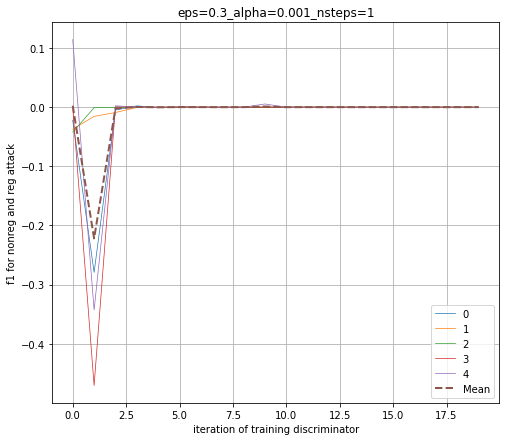

In [38]:
exp_path = 'results/Ford_A/Gegular/Discriminator_pickle/'

alpha = 0.001
eps = 0.3
n_steps = 1

exp_name = {'reg':f'fgsm_attack_eps={eps}_nsteps={n_steps}', 
            'noreg': f'fgsm_reg_attack_eps={eps}_alpha={alpha}_nsteps={n_steps}'}

visualization_differences(exp_name, exp_path, title=f'eps={eps}_alpha={alpha}_nsteps={n_steps}')

f1 final:  1.0


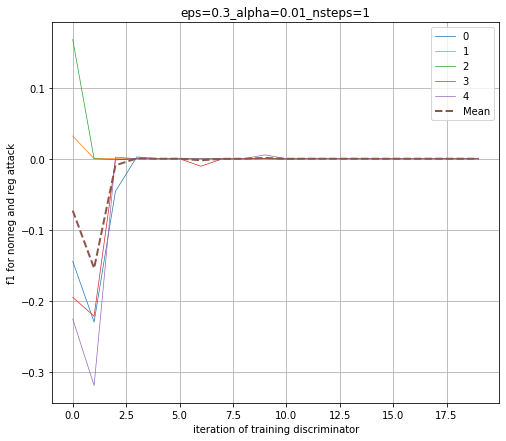

In [39]:
exp_path = 'results/Ford_A/Gegular/Discriminator_pickle/'

alpha = 0.01
eps = 0.3
n_steps = 1

exp_name = {'reg':f'fgsm_attack_eps={eps}_nsteps={n_steps}', 
            'noreg': f'fgsm_reg_attack_eps={eps}_alpha={alpha}_nsteps={n_steps}'}

visualization_differences(exp_name, exp_path, title=f'eps={eps}_alpha={alpha}_nsteps={n_steps}')

f1 final:  1.0


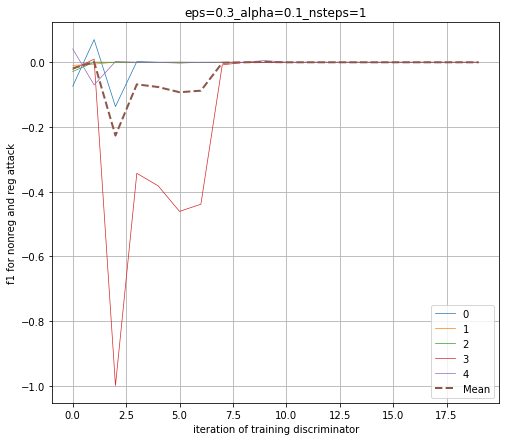

In [40]:
exp_path = 'results/Ford_A/Gegular/Discriminator_pickle/'

alpha = 0.1
eps = 0.3
n_steps = 1

exp_name = {'reg':f'fgsm_attack_eps={eps}_nsteps={n_steps}', 
            'noreg': f'fgsm_reg_attack_eps={eps}_alpha={alpha}_nsteps={n_steps}'}

visualization_differences(exp_name, exp_path, title=f'eps={eps}_alpha={alpha}_nsteps={n_steps}')

### many iteration

f1 final:  1.0


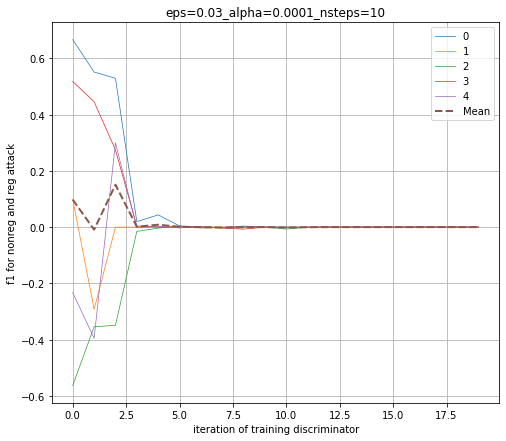

In [42]:
exp_path = 'results/Ford_A/Gegular/Discriminator_pickle/'

alpha = 0.0001
eps = 0.03
n_steps = 10

exp_name = {'reg':f'fgsm_attack_eps={eps}_nsteps={n_steps}', 
            'noreg': f'fgsm_reg_attack_eps={eps}_alpha={alpha}_nsteps={n_steps}'}

visualization_differences(exp_name, exp_path, title=f'eps={eps}_alpha={alpha}_nsteps={n_steps}')

f1 final:  0.9999619757405225


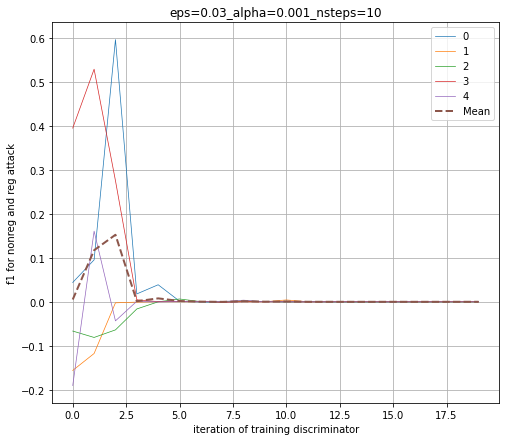

In [43]:
exp_path = 'results/Ford_A/Gegular/Discriminator_pickle/'

alpha = 0.001
eps = 0.03
n_steps = 10

exp_name = {'reg':f'fgsm_attack_eps={eps}_nsteps={n_steps}', 
            'noreg': f'fgsm_reg_attack_eps={eps}_alpha={alpha}_nsteps={n_steps}'}

visualization_differences(exp_name, exp_path, title=f'eps={eps}_alpha={alpha}_nsteps={n_steps}')

f1 final:  1.0


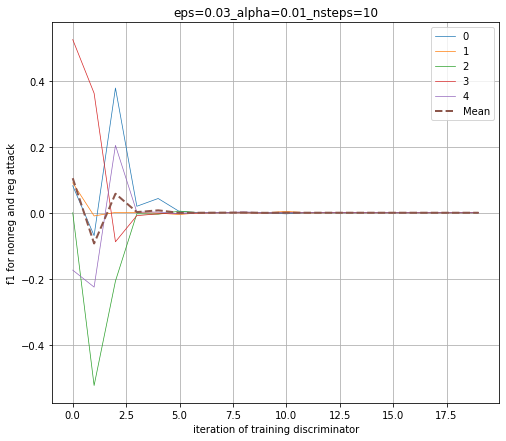

In [44]:
exp_path = 'results/Ford_A/Gegular/Discriminator_pickle/'

alpha = 0.01
eps = 0.03
n_steps = 10

exp_name = {'reg':f'fgsm_attack_eps={eps}_nsteps={n_steps}', 
            'noreg': f'fgsm_reg_attack_eps={eps}_alpha={alpha}_nsteps={n_steps}'}

visualization_differences(exp_name, exp_path, title=f'eps={eps}_alpha={alpha}_nsteps={n_steps}')